In [1]:
from geoalchemy2 import Geometry, load_spatialite
from sqlalchemy import event, Table, insert, func, select, text
from sqlalchemy.orm import sessionmaker
import os
from flask import Flask
import quickannotator.db.models as models
from quickannotator.db import db_session, init_db, Base
import large_image
import math
import numpy as np 
from shapely.geometry import Point, Polygon
import random
from shapely.affinity import translate
import json
from tqdm import tqdm
import shapely
from shapely.geometry import shape
from quickannotator.api.v1.annotation.helper import count_annotations_within_bbox, delete_all_annotations
from quickannotator.api.v1.tile.helper import reset_all_tiles_seen, get_tile_ids_within_bbox, point_to_tileid, upsert_tile
from quickannotator.api.v1.annotation_class.helper import get_annotation_class_by_id
from quickannotator.db.utils import build_annotation_table_name, create_dynamic_model
from quickannotator.api.v1.image.utils import get_image_by_id
from quickannotator.api.v1.tile.helper import get_tile_ids_intersecting_mask, tile_intersects_mask_shapely, get_all_tile_ids_for_image, tileid_to_rc
from quickannotator.api.v1.project.utils import add_project
from quickannotator.api.v1.image.utils import add_image_by_path
from quickannotator.api.v1.annotation.helper import create_annotation_table


/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-07 13:43:17,640	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
app = Flask("app")
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///quickannotator.db'
os.environ['SPATIALITE_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu/mod_spatialite.so'

init_db()

@app.teardown_appcontext
def shutdown_session(exception=None):
    if exception:
        db_session.rollback()
    else:
        try:
            db_session.commit()
        except Exception:
            db_session.rollback()
            raise
    db_session.remove()


In [3]:

    
def insert_annotation_class(project_id, name, color, magnification, patchsize, tilesize, dl_model_objectref):
    annotation_class = models.AnnotationClass(project_id=project_id,
                                        name=name,
                                        color=color,
                                        magnification=magnification,
                                        patchsize=patchsize,
                                        tilesize=tilesize,
                                        dl_model_objectref=dl_model_objectref)
    db_session.add(annotation_class)

            
def generate_random_polygon(max_area=10, centroid=(0, 0)):
    num_points = random.randint(10, 20)  # Polygons need at least 3 points

    # Generate points in polar coordinates
    radii = np.sqrt(np.random.uniform(0, 1, num_points))  # Square root ensures uniform distribution
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Convert polar coordinates to Cartesian coordinates
    points = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

    # Sort points to form a simple polygon
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[1], p[0]))

    # Create a Polygon and scale its area
    polygon = Polygon(sorted_points)

    # Calculate scaling factor
    current_area = polygon.area
    if current_area > 0:
        scaling_factor = np.sqrt(max_area / current_area)
        scaled_points = [(x * scaling_factor, y * scaling_factor) for x, y in sorted_points]
        polygon = Polygon(scaled_points)

    polygon = translate(polygon, xoff=centroid[0], yoff=centroid[1])

    return polygon
    
def generate_annotations(tilesize, image_width, image_height, n_polygons, image_id, annotation_class_id, gtpred):
    annotations = []
    for i in range(n_polygons):
        c = Point(np.random.randint(image_width), np.random.randint(image_height))
        
        poly: Polygon = generate_random_polygon(max_area=10000, centroid=(c.x, c.y))
        x = poly.centroid.x
        y = poly.centroid.y

        tile_id = point_to_tileid(tilesize, x, y, image_width, image_height)

        if tile_id:
            d = {
                "image_id": image_id,
                "annotation_class_id": annotation_class_id,
                "isgt": gtpred == "gt",
                "centroid": poly.centroid.wkt,  # Adding SRID=0 for pixel-based coordinates
                "area": poly.area,  # The area of the polygon
                "polygon": poly.wkt,  # Adding SRID=0 for the polygon
                "custom_metrics": {"iou": 0.5},  # Convert custom_metrics to a JSON string
                "tile_id": tile_id
            }
            annotations.append(d)
        
    return annotations

        
def insert_annotations(image_id, annotation_class_id, gtpred, annotations, is_geojson=False, is_mask=False):
    all_anno = []
    
    with app.app_context():
        image_width, image_height = get_image_dimensions(app, image_id)
        tilesize = get_annotation_class_by_id(annotation_class_id).tilesize
        tablename = build_annotation_table_name(image_id, annotation_class_id, gtpred)
        model = create_dynamic_model(tablename)

        for i, d in enumerate(tqdm(annotations)):
            if is_geojson:
                if not is_mask and d['properties']['classification']['name'] != 'tubule':
                    continue
                shapely_geometry = shape(d['geometry'])
            else:
                shapely_geometry = generate_random_polygon(max_area=10000, centroid=(np.random.randint(30, image_width - 30), np.random.randint(30, image_height - 30)))
            
            if is_mask:
                tile_id = None
            else:
                x = shapely_geometry.centroid.x
                y = shapely_geometry.centroid.y
                tile_id = get_tile_id_for_point(tilesize, x, y, image_width, image_height)
                upsert_tile(annotation_class_id, image_id, tile_id, hasgt=True)

            annotation = model(image_id=None,
                               annotation_class_id=None,
                               isgt=None,
                               centroid=shapely_geometry.centroid.wkt,
                               area=shapely_geometry.area,
                               polygon=shapely_geometry.wkt,
                               custom_metrics={"iou": 0.5},
                               tile_id=tile_id)
            
            all_anno.append(annotation)

            
            if len(all_anno) == 1_000:
                db_session.bulk_save_objects(all_anno)
                db_session.commit()
                all_anno = []
    
        if all_anno:
            db_session.bulk_save_objects(all_anno)
            db_session.commit()

def insert_existing_annotations(image_id, annotation_class_id, gtpred, filepath):
    path = filepath.split("quickannotator/")[1]
    with open(path, 'r') as file:
        data = json.load(file)
    insert_annotations(image_id, annotation_class_id, gtpred, data, is_geojson=True, is_mask=False)

def insert_generated_annotations(image_id, annotation_class_id, gtpred, n):
    annotations = [None] * n  # Placeholder for generating n annotations
    insert_annotations(image_id, annotation_class_id, gtpred, annotations, is_geojson=False, is_mask=False)

def insert_geojson_mask_file(image_id, annotation_class_id, gtpred, filepath):
    path = filepath.split("quickannotator/")[1]
    with open(path, 'r') as file:
        data = json.load(file)["features"]
    insert_annotations(image_id, annotation_class_id, gtpred, data, is_geojson=True, is_mask=True)



In [4]:
models = [Project, Image, AnnotationClass, Notification, Tile, Setting]
with app.app_context():
    Base.metadata.create_all(bind=db_session.bind, tables=[item.__table__ for item in models])
    create_annotation_table(1, 1, is_gt=True)
    create_annotation_table(1, 2, is_gt=True)
    create_annotation_table(1, 3, is_gt=True)
    create_annotation_table(2, 1, is_gt=True)
    create_annotation_table(2, 2, is_gt=True)
    create_annotation_table(2, 3, is_gt=True)

    create_annotation_table(1, 2, is_gt=False)
    create_annotation_table(1, 3, is_gt=False)
    create_annotation_table(2, 2, is_gt=False)
    create_annotation_table(2, 3, is_gt=False)
    

In [6]:
with db_session() as session:
    add_project(name="example_project", description="test", is_dataset_large=False)


In [7]:
with db_session() as session:
    add_image_by_path(
                        project_id=1,
                        full_path="quickannotator/data/test_ndpi/13_266069_040_003 L02 PAS.ndpi"
                        )

    add_image_by_path(
                        project_id=1,
                        full_path="quickannotator/data/test_ndpi/TCGA-23-2072-01Z-00-DX1.478243FF-BFF0-48A4-ADEA-DE789331A50E.svs")


In [8]:
with db_session() as session:
    insert_annotation_class(
                            project_id=None,
                            name="Tissue Mask",
                            color="black",
                            magnification=None,
                            patchsize=None,
                            tilesize=None,
                            dl_model_objectref=None)

    insert_annotation_class(
                            project_id=1,
                            name="Tubule",
                            color="red",
                            magnification=10,
                            patchsize=256,
                            tilesize=2048,
                            dl_model_objectref=None)

    insert_annotation_class(
                            project_id=1,
                            name="Lumen",
                            color="blue",
                            magnification=10,
                            patchsize=256,
                            tilesize=4096,
                            dl_model_objectref=None)


In [ ]:

insert_geojson_mask_file(app, db,
                            image_id=1,
                            annotation_class_id=1,
                            gtpred='gt',
                            filepath='quickannotator/data/test_ndpi/13_266069_040_003 L02 PAS_tissue_mask.geojson')


In [ ]:
insert_existing_annotations(app, db,
                            image_id=1,
                            annotation_class_id=2,
                            gtpred="gt",
                            filepath='quickannotator/data/test_ndpi/13_266069_040_003 L02 PAS.json'
                            )

In [ ]:

insert_geojson_mask_file(
                           image_id=2,
                           annotation_class_id=1,
                           gtpred='gt',
                           filepath='quickannotator/data/test_ndpi/TCGA-23-2072-01Z-00-DX1.478243FF-BFF0-48A4-ADEA-DE789331A50E_tissue_mask.geojson')


In [ ]:
insert_generated_annotations(image_id=2, annotation_class_id=2, gtpred="gt", n=1_000_000)
insert_generated_annotations(image_id=2, annotation_class_id=3, gtpred="gt", n=100_000)

## All code beyond this point is not related to populating the database and does not need to be run

In [ ]:
with app.app_context():
    image_id = 1
    annotatation_class_id = 2

    image = get_image_by_id(image_id)
    tilesize = get_annotation_class_by_id(annotatation_class_id).tilesize
    all_tile_ids = get_all_tile_ids_for_image(tile_size=tilesize, image_width=image.width, image_height=image.height)
    tile_ids_exact = [tile_id for tile_id in tqdm(all_tile_ids) if tile_intersects_mask_shapely(1, 2, tile_id)]

In [2]:
tile_ids_exact = [248,
 249,
 321,
 322,
 323,
 395,
 396,
 397,
 468,
 469,
 470,
 471,
 541,
 542,
 543,
 544,
 545,
 613,
 614,
 615,
 616,
 617,
 618,
 687,
 688,
 689,
 690,
 691,
 760,
 761,
 762,
 763,
 765,
 766,
 767,
 833,
 834,
 835,
 836,
 838,
 839,
 840,
 841,
 904,
 905,
 906,
 907,
 908,
 909,
 910,
 911,
 912,
 913,
 914,
 915,
 977,
 978,
 979,
 980,
 981,
 982,
 983,
 984,
 985,
 986,
 987,
 988,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1057,
 1058,
 1059,
 1060,
 1061,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1130,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1267,
 1268,
 1269,
 1270,
 1271,
 1272,
 1276,
 1277,
 1278,
 1279,
 1280,
 1281,
 1282,
 1283,
 1341,
 1342,
 1343,
 1344,
 1348,
 1349,
 1350,
 1351,
 1352,
 1353,
 1354,
 1355,
 1356,
 1357,
 1413,
 1414,
 1415,
 1416,
 1417,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1431,
 1487,
 1488,
 1489,
 1490,
 1494,
 1495,
 1496,
 1497,
 1498,
 1499,
 1500,
 1501,
 1502,
 1503,
 1504,
 1560,
 1561,
 1562,
 1563,
 1567,
 1568,
 1569,
 1570,
 1571,
 1573,
 1574,
 1575,
 1576,
 1633,
 1634,
 1635,
 1636,
 1637,
 1641,
 1642,
 1643,
 1644,
 1646,
 1647,
 1648,
 1649,
 1650,
 1706,
 1707,
 1708,
 1709,
 1710,
 1714,
 1715,
 1716,
 1717,
 1719,
 1720,
 1721,
 1722,
 1723,
 1780,
 1781,
 1782,
 1783,
 1787,
 1788,
 1789,
 1790,
 1792,
 1793,
 1794,
 1795,
 1796,
 1854,
 1855,
 1856,
 1859,
 1860,
 1861,
 1862,
 1863,
 1864,
 1865,
 1866,
 1867,
 1868,
 1869,
 1928,
 1929,
 1930,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 2001,
 2002,
 2003,
 2004,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2081,
 2082,
 2083,
 2084,
 2085,
 2086,
 2087,
 2147,
 2148,
 2149,
 2150,
 2151,
 2152,
 2155,
 2156,
 2157,
 2158,
 2159,
 2160,
 2161,
 2221,
 2222,
 2223,
 2224,
 2225,
 2229,
 2230,
 2231,
 2232,
 2233,
 2234,
 2303,
 2304,
 2305,
 2306,
 2307,
 2308,
 2378,
 2379,
 2380,
 2381,
 2453,
 2454]

In [3]:
# %%timeit
with db_session() as session:
    tileids, mask, polygons = get_tile_ids_intersecting_mask(1, 2, 1)

In [4]:
with db_session() as session:
    image = get_image_by_id(1)
    tilesize = get_annotation_class_by_id(2).tilesize


tiles_added = list(set(tileids) - set(tile_ids_exact))
tiles_missed = list(set(tile_ids_exact) - set(tileids))
tiles_shared = list(set(tileids) & set(tile_ids_exact))
coords_missed = [tileid_to_rc(tile_size=tilesize, tile_id=tileid, image_width=image.width, image_height=image.height) for tileid in tiles_missed]
coords_added = [tileid_to_rc(tile_size=tilesize, tile_id=tileid, image_width=image.width, image_height=image.height) for tileid in tiles_added]

print(f'tiles_added: {len(tiles_added)}')
print(f'tiles_missed: {tiles_missed}')
print(f'tiles_shared: {len(tiles_shared)}')

tiles_added: 119
tiles_missed: []
tiles_shared: 306


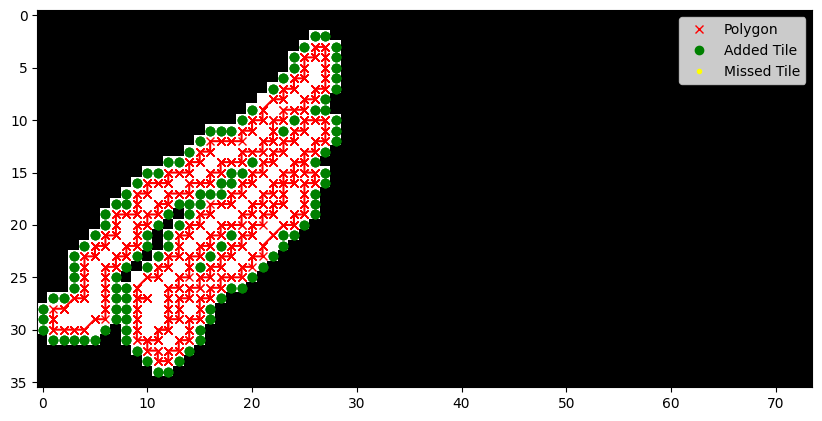

In [5]:
from shapely.geometry import Polygon
from shapely.wkt import loads as load_wkt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming `mask` and `polygons` are already defined
# mask: numpy array representing the mask
# polygons: list of WKT strings representing the polygons

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the mask
ax.imshow(mask, cmap='gray')

# Plot the polygons
for coords in polygons:
    # coords is shape of (n, 2)
    x, y = coords.T
    ax.plot(x, y, color='red', marker='x')
    # Plot the missed coordinates
    
    for coord in coords_added:
        ax.plot(coord[1], coord[0], color='green', marker='o')

    for coord in coords_missed:
        ax.plot(coord[1], coord[0], color='yellow', marker='.')

    # Add legend

legend_elements = [
    Line2D([0], [0], color='red', marker='x', linestyle='None', label='Polygon'),
    Line2D([0], [0], color='green', marker='o', linestyle='None', label='Added Tile'),
    Line2D([0], [0], color='yellow', marker='.', linestyle='None', label='Missed Tile')
]

ax.legend(handles=legend_elements, loc='upper right')

plt.show()